#  Competition Notebook: Car Price Prediction with CatBoost + Optuna


#  Setup & Imports

# Install necessary libraries


In [5]:
!pip install -q catboost optuna

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor, Pool, cv
import optuna
from google.colab import files
import re


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 29.3 MB/s eta 0:00:00



# Load Data



In [7]:
# Upload files
print("Please upload train.csv, test.csv, and sample_submission.csv")
uploaded = files.upload()

Please upload train.csv, test.csv, and sample_submission.csv


Saving test.csv to test.csv
Saving train.csv to train.csv
Saving sample_submission.csv to sample_submission.csv


In [8]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

print("Train shape:", train.shape)
print("Test shape:", test.shape)


Train shape: (188533, 13)
Test shape: (125690, 12)




#  Exploratory Data Analysis (EDA)



In [9]:

## 3.1 Data overview
display(train.head())
train.info()




,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


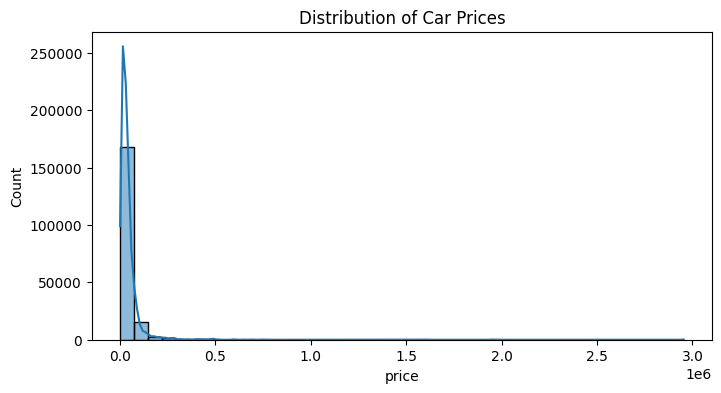

In [10]:
## 3.2 Target distribution
plt.figure(figsize=(8,4))
sns.histplot(train['price'], bins=40, kde=True)
plt.title("Distribution of Car Prices")
plt.show()




In [11]:
## 3.3 Missing values
missing = train.isnull().sum().sort_values(ascending=False)
print("Missing values:\n", missing[missing>0])



Missing values:
 clean_title    21419
fuel_type       5083
accident        2452
dtype: int64


In [12]:
## 3.4 Unique counts
print("\nUnique values per column:\n", train.nunique())




Unique values per column:
 id              188533
brand               57
model             1897
model_year          34
milage            6651
fuel_type            7
engine            1117
transmission        52
ext_col            319
int_col            156
accident             2
clean_title          1
price             1569
dtype: int64


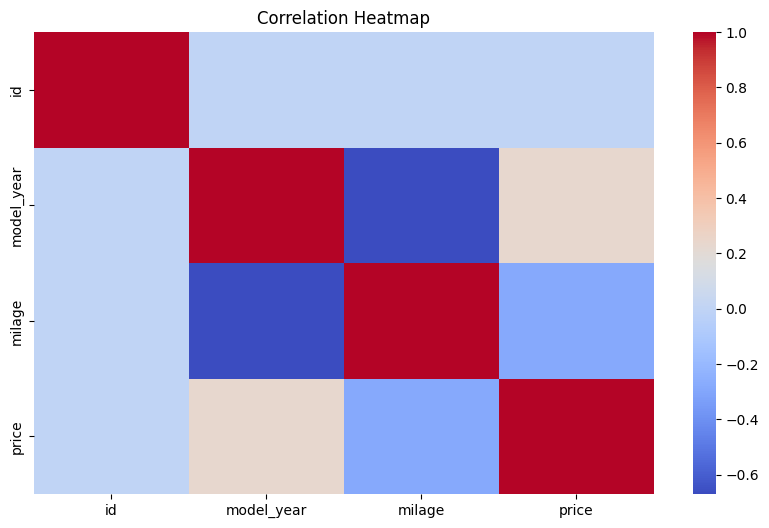

In [13]:
## 3.5 Correlation heatmap (numerical only)
plt.figure(figsize=(10,6))
sns.heatmap(train.corr(numeric_only=True), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap")
plt.show()


# 4. Preprocessing & Feature Engineering



In [14]:
target = 'price'
X = train.drop(columns=[target, 'id', 'clean_title'])
y = train[target]
X_test = test.drop(columns=['id', 'clean_title'])

# Categorical / numerical
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(exclude=['object']).columns.tolist()

# Fill categorical NaN
for col in cat_cols:
    X[col] = X[col].fillna('Unknown').astype(str)
    X_test[col] = X_test[col].fillna('Unknown').astype(str)

# Fuel type fix
if 'fuel_type' in X.columns:
    X['fuel_type'] = X['fuel_type'].replace('-', 'Unknown')
    X_test['fuel_type'] = X_test['fuel_type'].replace('-', 'Unknown')

# Frequency encode brand
def freq_encode(col, X, X_test):
    freq = X[col].value_counts(normalize=True)
    smoothing = 0.1
    global_mean = freq.mean()
    X[col+"_freq"] = X[col].map(freq) * (1-smoothing) + smoothing*global_mean
    X_test[col+"_freq"] = X_test[col].map(freq).fillna(global_mean) * (1-smoothing) + smoothing*global_mean
    return X, X_test

if 'brand' in X.columns:
    X, X_test = freq_encode('brand', X, X_test)
    cat_cols.remove('brand')
    num_cols.append('brand_freq')

# Extra engineered features
def extract_features(df):
    df['HP'] = df['engine'].str.extract(r'(\d+\.?\d*)HP').astype(float)
    df['Liter'] = df['engine'].str.extract(r'(\d+\.?\d*)L').astype(float)
    df['Cylinder'] = df['engine'].str.extract(r'(\d+) Cylinder').astype(float)
    df['Turbo'] = df['engine'].str.contains('Turbo', case=False, na=False).astype(int)
    df['Speed'] = df['transmission'].str.extract(r'(\d+)-Speed').astype(float)
    df['Auto'] = df['transmission'].str.contains('A/T|Automatic|Auto', case=False, na=False).astype(int)
    df['Manual'] = df['transmission'].str.contains('M/T|Manual', case=False, na=False).astype(int)
    current_year = 2025
    df['age'] = current_year - df['model_year']
    df['milage_per_year'] = df['milage'] / (df['age']+1e-5)
    df['log_milage'] = np.log1p(df['milage'])
    df['age_log_milage'] = df['age'] * df['log_milage']
    return df.drop(columns=['engine','transmission'])

X = extract_features(X)
X_test = extract_features(X_test)

# Update cols
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(exclude=['object']).columns.tolist()

# Fill numerical NaN with median
for col in num_cols:
    med = X[col].median()
    X[col] = X[col].fillna(med)
    X_test[col] = X_test[col].fillna(med)




# 5. Model Training with Optuna



In [15]:
def objective(trial):
    params = {
        'iterations': 600,
        'depth': trial.suggest_int('depth', 5, 7),
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.15),
        'random_strength': trial.suggest_float('random_strength', 1, 3),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.5, 2),
        'border_count': 128,
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 3, 6),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.7, 1.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 100),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'one_hot_max_size': 10,
        'grow_policy': 'Depthwise',
        'loss_function': 'RMSE',
        'task_type': 'CPU',
        'verbose': 0,
        'random_seed': 42
    }
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    train_pool = Pool(X_train, y_train, cat_features=cat_cols)
    val_pool = Pool(X_val, y_val, cat_features=cat_cols)
    model = CatBoostRegressor(**params)
    model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50, verbose=0)
    preds = model.predict(val_pool)
    return np.sqrt(mean_squared_error(y_val, preds))

study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=18)



[I 2025-09-14 20:17:13,535] A new study created in memory with name: no-name-983272ab-81af-4850-ac50-f600f77c903f
[I 2025-09-14 20:17:31,691] Trial 0 finished with value: 68188.99147977431 and parameters: {'depth': 6, 'learning_rate': 0.1450714306409916, 'random_strength': 2.46398788362281, 'bagging_temperature': 1.397987726295555, 'l2_leaf_reg': 3.4680559213273097, 'colsample_bylevel': 0.7467983561008608, 'min_data_in_leaf': 24, 'subsample': 0.9598528437324805}. Best is trial 0 with value: 68188.99147977431.
[I 2025-09-14 20:17:45,850] Trial 1 finished with value: 68124.84987383851 and parameters: {'depth': 6, 'learning_rate': 0.12080725777960455, 'random_strength': 1.041168988591605, 'bagging_temperature': 1.9548647782429915, 'l2_leaf_reg': 5.497327922401265, 'colsample_bylevel': 0.7637017332034828, 'min_data_in_leaf': 34, 'subsample': 0.7550213529560301}. Best is trial 1 with value: 68124.84987383851.
[I 2025-09-14 20:18:11,826] Trial 2 finished with value: 68161.40118561927 and par


# 6. Validation Performance



In [16]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
train_pool = Pool(X_train, y_train, cat_features=cat_cols)
val_pool = Pool(X_val, y_val, cat_features=cat_cols)
model = CatBoostRegressor(**study.best_params, task_type='CPU', verbose=0)
model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50)

preds = model.predict(val_pool)
rmse = np.sqrt(mean_squared_error(y_val, preds))
print(f"Validation RMSE: {rmse:.4f}")



Validation RMSE: 68019.2921



# 7. Feature Importance



/tmp/ipython-input-1074523287.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp.head(20), x='Importance', y='Feature', palette='viridis')


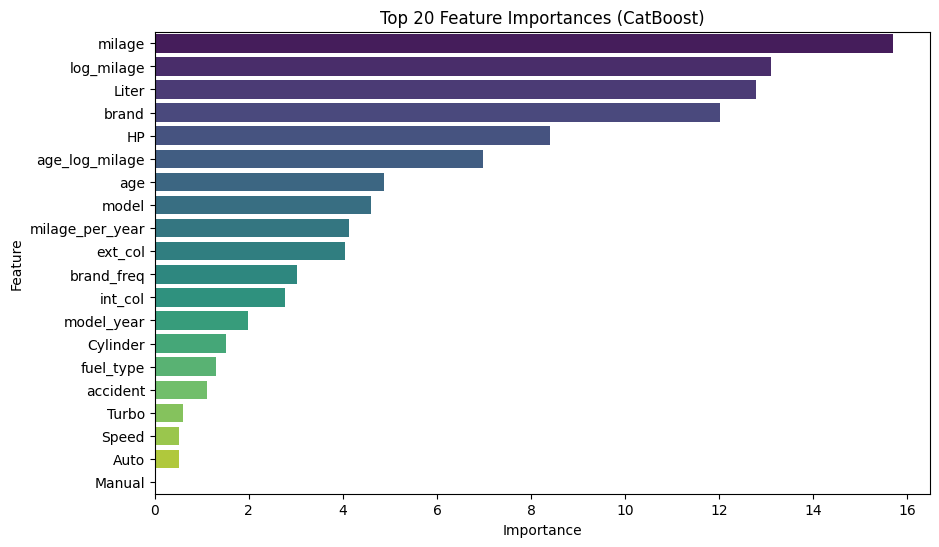

In [17]:
importances = model.get_feature_importance(train_pool)
feat_names = X_train.columns

feat_imp = pd.DataFrame({
    'Feature': feat_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=feat_imp.head(20), x='Importance', y='Feature', palette='viridis')
plt.title("Top 20 Feature Importances (CatBoost)")
plt.show()




# 8. Final Model & Submission




In [19]:
final_params = study.best_params
final_params.update({'loss_function':'RMSE','task_type':'CPU','verbose':100})

train_pool = Pool(X, y, cat_features=cat_cols)
test_pool = Pool(X_test, cat_features=cat_cols)

final_model = CatBoostRegressor(**final_params)
final_model.fit(train_pool)

submission[target] = final_model.predict(test_pool)
submission.to_csv('submission_enhanced_plus.csv', index=False)
files.download('submission_enhanced_plus.csv')
print(" Submission saved as submission_enhanced_plus.csv")

0:	learn: 78223.7923310	total: 321ms	remaining: 5m 20s
100:	learn: 72735.6468329	total: 17.7s	remaining: 2m 37s
200:	learn: 72423.3100470	total: 33.3s	remaining: 2m 12s
300:	learn: 72204.0690873	total: 49.6s	remaining: 1m 55s
400:	learn: 71973.1755518	total: 1m 5s	remaining: 1m 37s
500:	learn: 71739.0769282	total: 1m 21s	remaining: 1m 20s
600:	learn: 71518.3072076	total: 1m 38s	remaining: 1m 5s
700:	learn: 71353.4965467	total: 1m 56s	remaining: 49.5s
800:	learn: 71188.8154053	total: 2m 12s	remaining: 32.8s
900:	learn: 70992.0000422	total: 2m 29s	remaining: 16.4s
999:	learn: 70846.8340712	total: 2m 46s	remaining: 0us


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 Submission saved as submission_enhanced_plus.csv
